# Faza 1

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, pearsonr, levene, ttest_ind
from sklearn.preprocessing import LabelEncoder

## 1.1 A

Reading dataframe, separator is tab

In [78]:
conn_df = pd.read_csv("data\\connections.csv", sep="\t")
proc_df = pd.read_csv("data\\processes.csv", sep="\t")
devices_df = pd.read_csv("data\\devices.csv", sep="\t")
profiles_df = pd.read_csv("data\\profiles.csv", sep="\t")

### Size each dataframe

In [79]:
print("Connections size (rows, columns):", conn_df.shape)
print("Processes size (rows, columns):", proc_df.shape)
print("Devices size (rows, columns):", devices_df.shape)
print("Profiles size (rows, columns):", profiles_df.shape)

Connections size (rows, columns): (15143, 13)
Processes size (rows, columns): (15143, 23)
Devices size (rows, columns): (2963, 6)
Profiles size (rows, columns): (2537, 12)


### Types of attributes

In [80]:
conn_df.dtypes

ts                    object
imei                   int64
mwra                 float64
c.dogalize           float64
c.android.chrome     float64
c.katana             float64
c.android.youtube    float64
c.android.gm         float64
c.updateassist       float64
c.android.vending    float64
c.UCMobile.intl      float64
c.UCMobile.x86       float64
c.raider             float64
dtype: object

Types are imported correctly

In [81]:
proc_df.dtypes

ts                             object
imei                            int64
mwra                          float64
p.android.packageinstaller    float64
p.android.documentsui         float64
p.android.chrome              float64
p.android.settings            float64
p.android.externalstorage     float64
p.android.gm                  float64
p.system                      float64
p.browser.provider            float64
p.notifier                    float64
p.simulator                   float64
p.gms.persistent              float64
p.katana                      float64
p.android.defcontainer        float64
p.process.gapps               float64
p.olauncher                   float64
p.dogalize                    float64
p.android.vending             float64
p.google                      float64
p.inputmethod.latin           float64
p.android.gms                 float64
dtype: object

Types are imported correctly

In [82]:
devices_df.dtypes

latitude      float64
longitude     float64
store_name     object
code           object
location       object
imei            int64
dtype: object

Types are imported correctly

In [83]:
profiles_df.dtypes

registration        object
username            object
residence           object
company             object
name                object
birthdate           object
ssn                 object
mail                object
user_id              int64
current_location    object
imei                 int64
job                 object
dtype: object

Types are imported correctly

There is no sign of mistype in any of these dataframes

In [84]:
print("Connections attributes:", *conn_df.columns)
print("Processes attributes:", *proc_df.columns)
print("Devices attributes:", *devices_df.columns)
print("Profiles attributes:", *profiles_df.columns)


Connections attributes: ts imei mwra c.dogalize c.android.chrome c.katana c.android.youtube c.android.gm c.updateassist c.android.vending c.UCMobile.intl c.UCMobile.x86 c.raider
Processes attributes: ts imei mwra p.android.packageinstaller p.android.documentsui p.android.chrome p.android.settings p.android.externalstorage p.android.gm p.system p.browser.provider p.notifier p.simulator p.gms.persistent p.katana p.android.defcontainer p.process.gapps p.olauncher p.dogalize p.android.vending p.google p.inputmethod.latin p.android.gms
Devices attributes: latitude longitude store_name code location imei
Profiles attributes: registration username residence company name birthdate ssn mail user_id current_location imei job


We can notice, that all dataframes have *imei* attribute in it. IMEI stands for _International Mobile Equipment Identity_. So each row just represent particular data about single android device.

We can also notice, that connections and procecesses have the same naumber of rows and both have attribute called ts which stands for timestamp. It suggests that it might be logging of both connections and processes at the particular point in time:

In [85]:
(conn_df["ts"] == proc_df["ts"]).sum()

15143

In [86]:
(conn_df["imei"] == proc_df["imei"]).sum()

15143

In [87]:
(conn_df["mwra"] == proc_df["mwra"]).sum()

15143

As we can see, the IMEI and TS are equal for each record in these two datasets which proves suggestion.

The devices dataframe may give an insight in the source of the devices (i.e. the place and time of purchase). The profiles dataframe may provide us an information of the users of the devices.

However, there is not much attributes to link connections or processes with devcies or profiles except IMEI field.

In [88]:
devices_df["imei"].unique().shape

(498,)

In [89]:
devices_df["imei"].shape

(2963,)

In [90]:
profiles_df["imei"].unique().shape

(495,)

In [91]:
profiles_df["imei"].shape

(2537,)

We can see that both profiles and devices have only around 500 unique IMEI records out of \~2500/\~3000 total records. So, most probably, these record just represent data related to particular phone.

## 1.1B

Main numeric values are in processes and connections dataframes, so we will analyze attributes from these two dataframes.

Let's see distributions for all processes in processes_df:

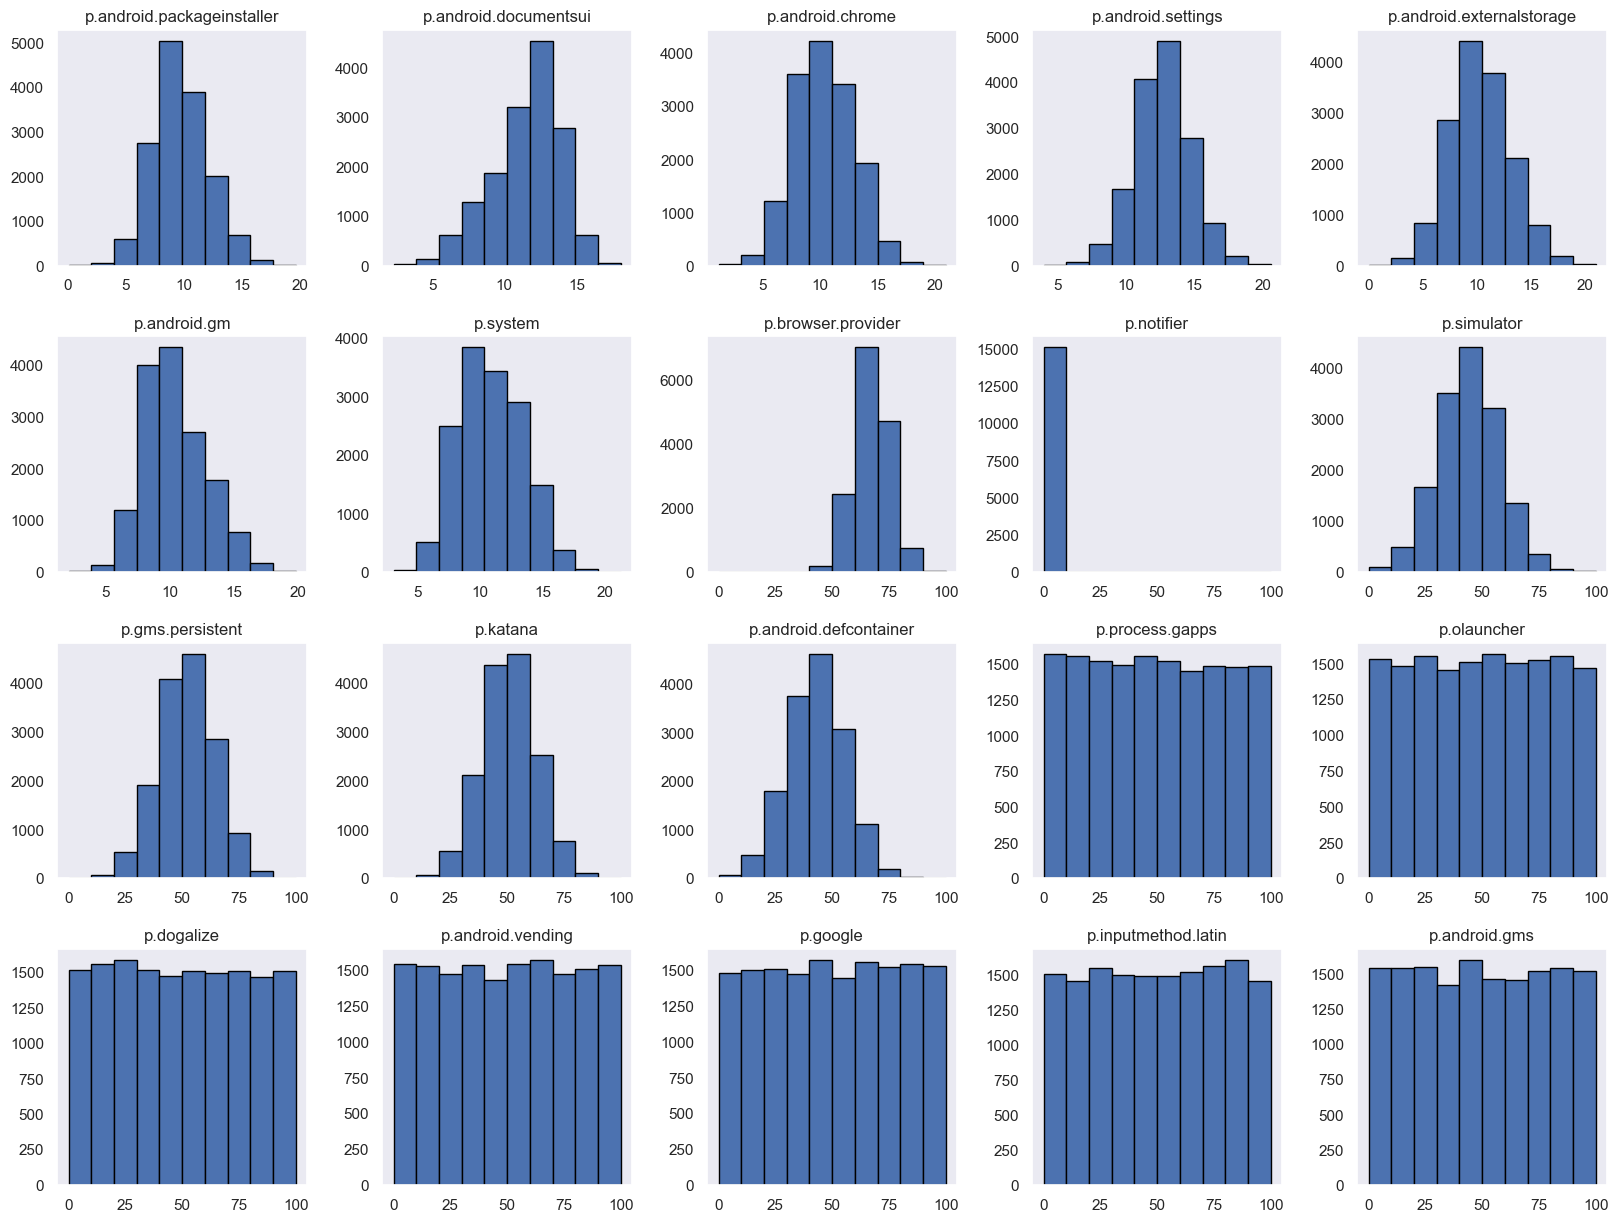

In [92]:
proc_attributes =  proc_df.select_dtypes("float")
proc_attrs = proc_attributes.loc[:, proc_attributes.columns != 'mwra']
fig, axis = plt.subplots(4, 5, figsize=(20,15))
proc_attrs.hist(ax=axis, edgecolor='black', grid=False)
plt.show()

We can also get the list of normally distributed attributes using Shapiro-Wilk test:

In [93]:
proc_norm_list = []
proc_not_norm_list = []
for column in proc_attrs:
    if shapiro(proc_attrs[column]).pvalue > 0.05:
        proc_norm_list.append(column)
    else:
        proc_not_norm_list.append(column)
print("Normally distributed processes:", proc_norm_list)

Normally distributed processes: ['p.simulator', 'p.gms.persistent', 'p.katana', 'p.android.defcontainer']


C:\Users\milan\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15143.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk revealed which attributes normally distributed and which attributes aren't:

In [94]:
proc_norm = proc_attrs[proc_norm_list]
proc_notnorm = proc_attrs[proc_not_norm_list]
proc_norm = pd.concat([proc_norm, proc_df["mwra"]], axis=1)
proc_norm

,p.simulator,p.gms.persistent,p.katana,p.android.defcontainer,mwra
0,35.71788,51.77164,40.23305,41.76549,1.0
1,29.55507,46.06186,66.35247,53.31959,0.0
2,32.34265,54.17242,46.94977,39.23991,0.0
3,63.09837,67.07612,49.81393,38.59364,0.0
4,42.41401,58.73573,50.35359,65.09269,1.0
...,...,...,...,...,...
15138,31.43787,68.53845,44.58185,43.78864,1.0
15139,42.81895,36.46882,39.13095,38.62800,0.0
15140,44.83145,65.44567,60.74023,33.61657,0.0
15141,47.39006,28.86566,49.14036,59.81838,0.0


Let's see the descriptive statistics for the attributes:

In [95]:
proc_attrs.describe()

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,p.gms.persistent,p.katana,p.android.defcontainer,p.process.gapps,p.olauncher,p.dogalize,p.android.vending,p.google,p.inputmethod.latin,p.android.gms
count,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000
mean,9.734081,11.530321,10.354774,12.701517,10.285296,10.386558,10.892521,67.266917,0.180368,44.079895,51.967771,50.942925,42.902683,49.438710,50.007092,49.688617,50.022847,50.306934,50.250174,49.866868
std,2.353793,2.379354,2.560366,2.043104,2.789514,2.421371,2.553577,7.803221,1.708792,13.527190,12.468146,12.141770,12.657218,28.929395,28.845051,28.905844,28.934729,28.828845,28.813387,28.957585
min,0.107530,2.332460,1.157840,4.014640,0.000000,2.147780,3.127180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.108805,10.096745,8.508865,11.406915,8.352360,8.629830,8.959910,62.003040,0.001250,34.903330,43.637225,42.925860,34.388385,24.499375,24.976120,24.443920,24.924490,25.287315,25.572440,24.546590
50%,9.568570,11.921050,10.227180,12.707480,10.138900,10.030590,10.715680,67.277050,0.008600,44.087750,52.027850,50.908870,42.946220,49.204370,50.321980,49.587050,50.386190,50.211930,50.450770,49.557470
75%,11.209280,13.238575,12.194415,14.029885,12.103005,11.982615,12.780965,72.435125,0.049075,53.216140,60.404405,59.073945,51.431855,74.628445,74.997115,74.786680,74.904195,75.321355,75.259580,75.016335
max,19.659630,18.067980,20.966080,20.586340,20.975710,19.808420,21.229940,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Let's see distributions for all connections in conn_df:

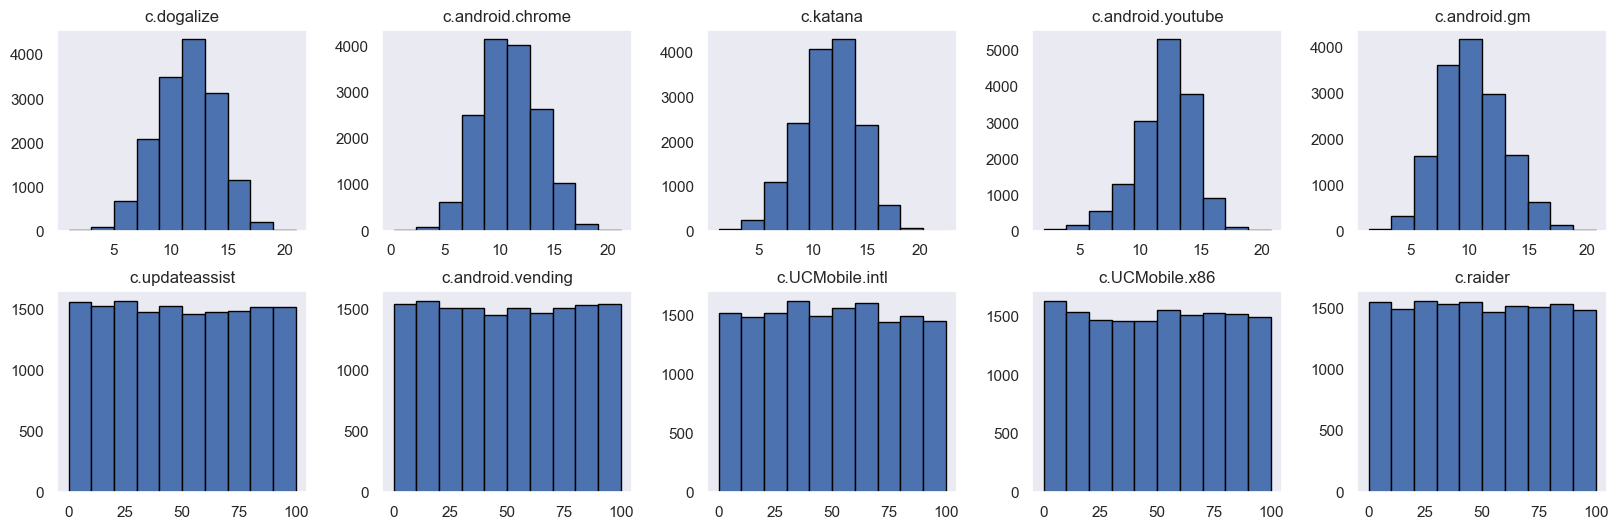

In [96]:
conn_attributes =  conn_df.select_dtypes("float")
conn_attrs = conn_attributes.loc[:, conn_attributes.columns != 'mwra']
fig, axis = plt.subplots(2, 5, figsize=(20,6))
conn_attrs.hist(ax=axis, edgecolor='black', grid=False)
plt.show()

Histograms revealed that attributes before c.updateassist are normally distributed, while the others aren't:

In [97]:
conn_norm = conn_attrs.loc[:, :"c.android.gm"]
conn_notnorm = conn_attrs.loc[:, "c.updateassist":]
conn_norm = pd.concat([conn_norm, conn_df["mwra"]], axis=1)
conn_norm[conn_norm["mwra"] == 1]

,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,mwra
0,11.97002,15.25610,10.99463,12.94905,9.87441,1.0
4,9.08043,14.14611,9.68923,13.12646,8.82400,1.0
5,13.33874,15.94627,10.55827,12.33971,10.56274,1.0
6,16.70785,14.63996,14.16997,15.02633,2.90955,1.0
11,8.71281,11.20755,13.55143,11.79122,13.87891,1.0
...,...,...,...,...,...,...
15132,9.86349,14.98360,9.80777,8.65737,9.60043,1.0
15133,12.25497,8.32633,10.88130,12.51090,8.49994,1.0
15134,12.69147,8.72604,8.95936,12.50919,12.68571,1.0
15138,13.17188,9.06209,9.73345,13.07588,13.36728,1.0


Let's see the descriptive statistics for the attributes:

In [98]:
conn_attrs.describe()

,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
count,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000
mean,11.452411,10.900475,11.534564,12.061295,10.253361,49.690945,49.875202,49.711246,49.648245,49.770309
std,2.661398,2.703876,2.785804,2.325038,2.687359,28.980529,29.008906,28.682976,29.062244,28.850271
min,1.026250,0.291220,1.260930,2.053830,1.482300,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.571635,8.944125,9.717075,10.798585,8.360420,24.689315,24.641910,25.329615,24.236540,24.686350
50%,11.564450,10.834810,11.685900,12.323720,10.064370,49.265910,49.907250,49.800630,50.150860,49.457960
75%,13.314445,12.804725,13.526230,13.606590,12.044015,74.881965,75.355220,74.043395,74.871090,74.819100
max,20.936100,21.131390,22.379300,20.731990,20.710370,100.000000,100.000000,100.000000,100.000000,100.000000


Let's concatenate connections and processes into a single dataframe:

In [99]:
numeric_attrs = pd.concat([proc_attrs, conn_attrs], axis=1)
numeric_attrs

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,65.46982,0.01284,35.71788,...,11.97002,15.25610,10.99463,12.94905,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727
1,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,73.15339,0.00082,29.55507,...,9.06416,8.26843,12.37275,12.62434,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586
2,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,68.51992,0.00378,32.34265,...,10.71737,10.70129,11.52100,12.78995,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044
3,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,69.41012,0.00725,63.09837,...,11.38573,10.28395,14.22024,12.20206,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979
4,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,57.32590,0.00087,42.41401,...,9.08043,14.14611,9.68923,13.12646,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,65.77796,0.04257,31.43787,...,13.17188,9.06209,9.73345,13.07588,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666
15139,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,70.88634,0.00023,42.81895,...,7.28806,10.61374,9.49010,9.77496,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351
15140,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,68.88885,0.00018,44.83145,...,7.35113,10.57486,18.32629,13.34462,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706
15141,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,69.60882,0.00430,47.39006,...,10.86261,16.25512,10.77980,5.68572,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017


Since connections and proccess share same ts, imei and mwra, let's add them too:

In [100]:
numeric_attrs = pd.concat([proc_df[["ts", "imei", "mwra"]], numeric_attrs], axis=1)
numeric_attrs

,ts,imei,mwra,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,2018-05-05 10:00:00,3590433799317662121,1.0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,...,11.97002,15.25610,10.99463,12.94905,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727
1,2018-05-05 10:01:00,3590433799317661875,0.0,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,...,9.06416,8.26843,12.37275,12.62434,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586
2,2018-05-05 10:02:00,3590433799317662436,0.0,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,...,10.71737,10.70129,11.52100,12.78995,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044
3,2018-05-05 10:03:00,359043379931766726,0.0,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,...,11.38573,10.28395,14.22024,12.20206,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979
4,2018-05-05 10:04:00,359043379931766098,1.0,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,...,9.08043,14.14611,9.68923,13.12646,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,2018-05-08 11:33:00,359043379931766304,1.0,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,...,13.17188,9.06209,9.73345,13.07588,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666
15139,2018-05-11 06:21:00,8630330696303481206,0.0,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,...,7.28806,10.61374,9.49010,9.77496,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351
15140,2018-05-15 09:30:00,863033069630348222,0.0,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,...,7.35113,10.57486,18.32629,13.34462,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706
15141,2018-05-10 23:44:00,863033069630348693,0.0,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,...,10.86261,16.25512,10.77980,5.68572,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017


Let's also concatenate both normally distributed attributes and not normally distributed parameters:

In [101]:
numeric_norm = pd.concat([proc_df[["ts", "imei", "mwra"]], proc_norm, conn_norm], axis=1)
numeric_notnorm = pd.concat([proc_df[["ts", "imei", "mwra"]], proc_notnorm, conn_notnorm], axis=1)

## 1.1C & 1.1D

For those normally distributed attributes, Pearson's correlation will be applied to determine if there any link between attributes:

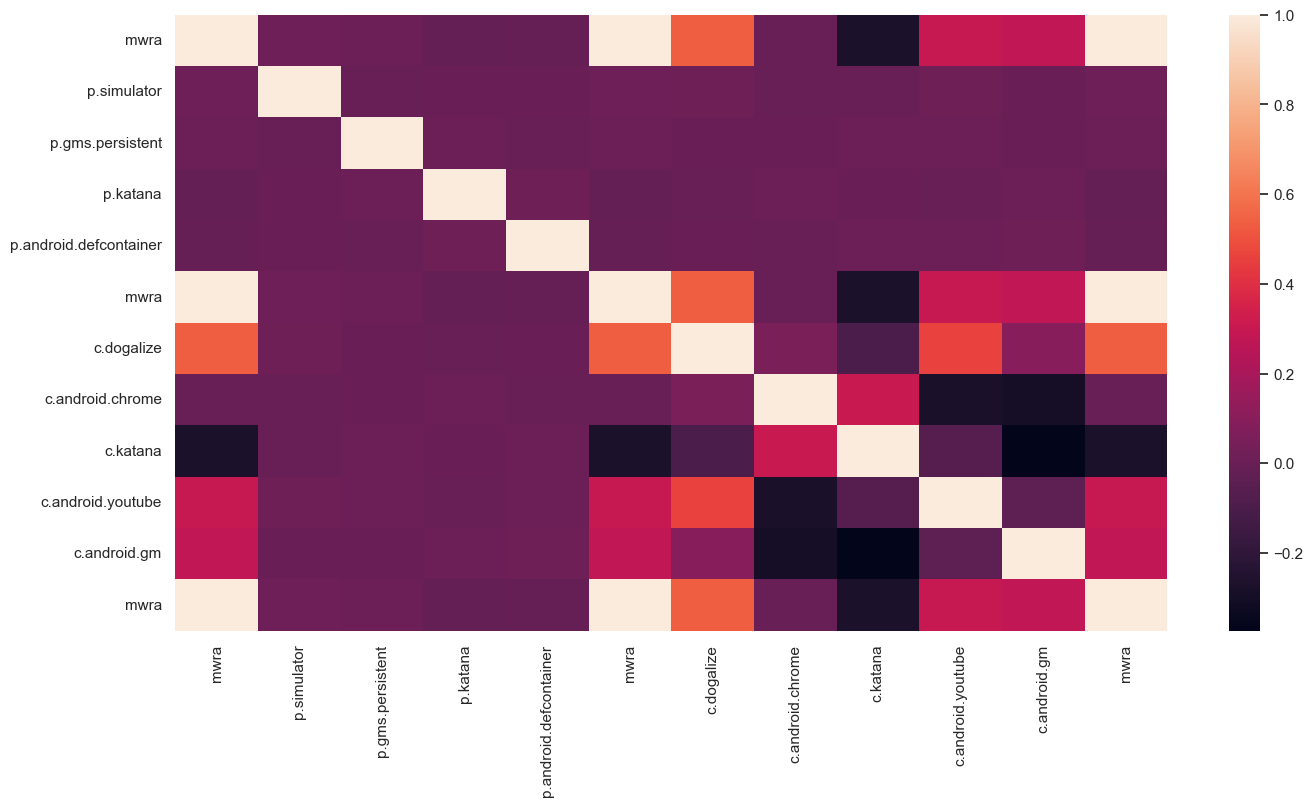

In [102]:
sns.heatmap(data=numeric_norm.select_dtypes("float").corr(method="pearson"))
plt.show()

For those not normally distributed, Spearman's correlation will be aplied:

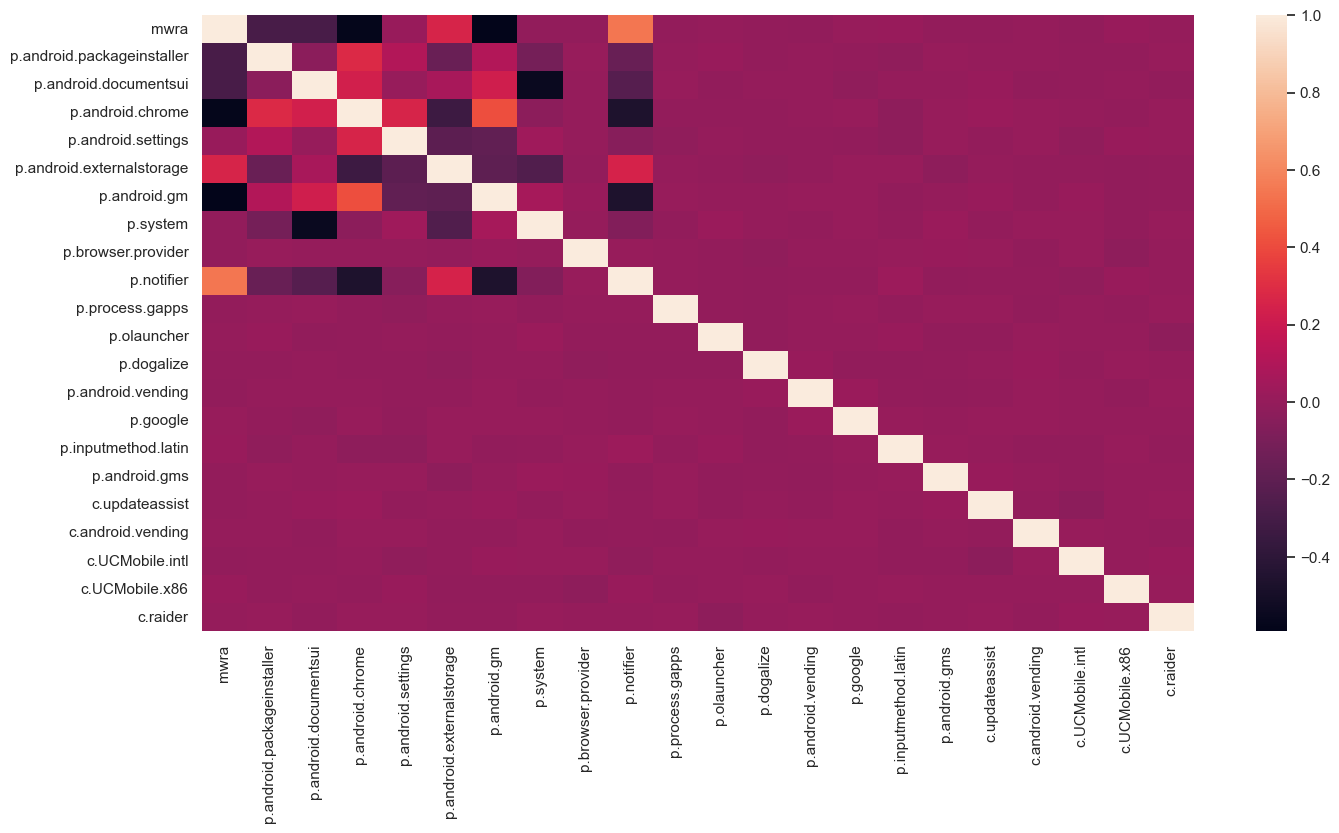

In [103]:
sns.heatmap(data=numeric_notnorm.select_dtypes("float").corr(method="spearman"))
plt.show()

We can see no correlation has been found there between those not normally distributed.

## 1.1E

There are couple of insights that heatmap may give us:
1) Chrome (browser) service \[perhaps\] often works with documents (documentsui), gmail services (gm), settings and package installer. And doesn't with external storage.
2) External storage \[perhaps\] often utilized by web connections (dogalize, chrome, katana, youtube)
3) Perhaps, dogalize connection doesn't let chrome and gmail proccess to operate normally. Meanwhile, it does work actively with notifications and \[perhaps\] launches youtube connections.

There are also correlations between target attribute and others:
1) Connections with youtube, dogalize and gmail may be potential source of malware activity.
2) Working with external storage may potentially be dangerous.
3) Probably, gmail service and chrome services run their own protections as it can explain strong negative correlation.

# 1.2

## 1.2A

As it can be seen in both connections and processes dataframes data is comlete and has no issues (all the values are present and consistent, format is rigorious).

In [104]:
print(conn_df.isnull().sum().sum(), proc_df.isnull().sum().sum())

0 0


So here we will mainly focus on devices and profiles dataframes:

#### Devices

In [105]:
devices_df.isnull().sum()

latitude      0
longitude     0
store_name    0
code          3
location      0
imei          0
dtype: int64

Let's find these three records which have empty values in codes

In [106]:
devices_df[devices_df["code"].isnull()]

,latitude,longitude,store_name,code,location,imei
1591,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,3590433799317662493
1598,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,359043379931766783
2408,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,863033069630348370


As Windhoek is located in Republic of Namibia, let's use it's ISO-2 code to fill in the data: 

In [107]:
devices_df.loc[devices_df["code"].isnull(), "code"] = "NA"
devices_df[devices_df["code"] == "NA"]

,latitude,longitude,store_name,code,location,imei
1591,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,3590433799317662493
1598,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,359043379931766783
2408,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,863033069630348370


Let's also check coordinates, since we know that the valid range of latitude in degrees is -90 and +90 for the southern and northern hemisphere, respectively. Longitude is in the range -180 and +180:

In [108]:
devices_df[(-180 <= devices_df["longitude"]) & (devices_df["longitude"] <= 180) & (-90 <= devices_df["latitude"]) & (devices_df["latitude"] <= 90)].shape

(2963, 6)

All coordinates are valid

In [109]:
devices_cleandf = devices_df

#### Profiles

Let's firstly estimate the number of empty values in each column:

In [110]:
profiles_df.isnull().sum()

registration           0
username               0
residence           1649
company                0
name                   0
birthdate           1142
ssn                    0
mail                   0
user_id                0
current_location     127
imei                   0
job                 1776
dtype: int64

In [111]:
profiles_df.shape

(2537, 12)

In [112]:
print("Residence empty (%):", 1649 / 2527 * 100)
print("birthdate empty (%):", 1142 / 2527 * 100)
print("current_location empty (%):", 127 / 2527 * 100)
print("job empty (%):", 1776 / 2527 * 100)

Residence empty (%): 65.25524337158686
birthdate empty (%): 45.19192718638702
current_location empty (%): 5.0257222002374355
job empty (%): 70.2809655718243


It makes sense to drop residence and job columns as this value can be hardly substited and actually mostly are not presented in dataset.

In [113]:
profiles_cleandf = profiles_df.drop(["residence", "job"], axis=1)
profiles_cleandf

,registration,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019/09/09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,26 Oct 2022,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023/11/12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018/01/04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057
...,...,...,...,...,...,...,...,...,...,...
2532,2018/12/21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,NaN,518-35-4627,brandonho@yahoo.com,1787,NaN,3590433799317662329
2533,"10/16/2018, 00:00:00",downsdarin,"Gill, Downs and Esparza",Michael Dodson,1965-01-15,382-24-1772,antoniomay@yahoo.com,1422,"(Decimal('45.428582'), Decimal('-99.719827'))",359043379931766643
2534,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,1924-04-08,677-27-7010,simpsontracy@gmail.com,2429,"(Decimal('-65.724331'), Decimal('71.251540'))",863033069630348537
2535,"10/14/2021, 00:00:00",olivia11,Andrade-Rivera,Valerie Sanchez,2007-06-12,138-75-9242,gdavis@hotmail.com,19,"(Decimal('37.6123115'), Decimal('104.117267'))",359043379931766858


Further work regarding missing values will be done in 1.2B. Now let's see which columns have an inconsistent or inappropriate format:

In [114]:
profiles_cleandf.head()

,registration,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019/09/09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,26 Oct 2022,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023/11/12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018/01/04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057


It's obvious that registration has inconsistent format and current_location provides inconviniet format for futher processing. Let's firstly deal with registration.

In [115]:
from dateutil.parser import parse # To parse unknown datetime format
from datetime import datetime

In [116]:
parse(profiles_cleandf.iloc[0, 0], fuzzy=True)

datetime.datetime(2019, 9, 9, 0, 0)

That's how this util works, now let's create new column which will hold datetime values in a single unified format yyyy-dd-mm:

In [117]:
profiles_cleandf.insert(0, "regdate", profiles_cleandf["registration"].apply(parse, fuzzy=True))
profiles_cleandf.drop("registration", axis=1, inplace=True)
profiles_cleandf

,regdate,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019-09-09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,2022-10-26,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023-11-12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018-01-04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057
...,...,...,...,...,...,...,...,...,...,...
2532,2018-12-21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,NaN,518-35-4627,brandonho@yahoo.com,1787,NaN,3590433799317662329
2533,2018-10-16,downsdarin,"Gill, Downs and Esparza",Michael Dodson,1965-01-15,382-24-1772,antoniomay@yahoo.com,1422,"(Decimal('45.428582'), Decimal('-99.719827'))",359043379931766643
2534,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,1924-04-08,677-27-7010,simpsontracy@gmail.com,2429,"(Decimal('-65.724331'), Decimal('71.251540'))",863033069630348537
2535,2021-10-14,olivia11,Andrade-Rivera,Valerie Sanchez,2007-06-12,138-75-9242,gdavis@hotmail.com,19,"(Decimal('37.6123115'), Decimal('104.117267'))",359043379931766858


It's also obvious  that current_location is in the unconvinient format too, let's parse it into two new columns: longitude and latitude:

In [118]:
import re
def get_latitude(value):
    if pd.isnull(value):
        return np.nan
    result = tuple(map(float, re.findall(r"-?\d*\.\d*", value)))
    if not result:
        return np.nan
    return result[0]
    
def get_longitude(value):
    if pd.isnull(value):
        return np.nan
    result = tuple(map(float, re.findall(r"-?\d*\.\d*", value)))
    if not result:
        return np.nan
    return result[1]

#profiles_cleandf["latitude"], profiles_cleandf["longitude"] = profiles_cleandf["current_location"].apply(get_coordinates)
#profiles_cleandf
profiles_cleandf["latitude"] = profiles_cleandf["current_location"].apply(get_latitude)
profiles_cleandf["longitude"] = profiles_cleandf["current_location"].apply(get_longitude)
profiles_cleandf.drop("current_location", axis=1, inplace=True)
profiles_cleandf

,regdate,username,company,name,birthdate,ssn,mail,user_id,imei,latitude,longitude
0,2019-09-09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,8630330696303482345,-35.486660,-126.966117
1,2022-10-26,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,863033069630348305,-71.257775,-24.088612
2,2023-11-12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,863033069630348529,15.550242,74.236302
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,3590433799317661347,76.283353,-1.336879
4,2018-01-04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,863033069630348057,-1.282221,25.470396
...,...,...,...,...,...,...,...,...,...,...,...
2532,2018-12-21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,NaN,518-35-4627,brandonho@yahoo.com,1787,3590433799317662329,NaN,NaN
2533,2018-10-16,downsdarin,"Gill, Downs and Esparza",Michael Dodson,1965-01-15,382-24-1772,antoniomay@yahoo.com,1422,359043379931766643,45.428582,-99.719827
2534,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,1924-04-08,677-27-7010,simpsontracy@gmail.com,2429,863033069630348537,-65.724331,71.251540
2535,2021-10-14,olivia11,Andrade-Rivera,Valerie Sanchez,2007-06-12,138-75-9242,gdavis@hotmail.com,19,359043379931766858,37.612311,104.117267


Let's check that we have the same 127 missing values and no more added

In [119]:
profiles_cleandf.isnull().sum()

regdate         0
username        0
company         0
name            0
birthdate    1142
ssn             0
mail            0
user_id         0
imei            0
latitude      127
longitude     127
dtype: int64

## 1.2B

Let's firstly resolve the missing latitude and longitdude. For every missing value let's use interpolation.

In [120]:
profiles_cleandf["latitude"] = profiles_cleandf["latitude"].interpolate(method='linear')
profiles_cleandf["longitude"] = profiles_cleandf["longitude"].interpolate(method='linear')
profiles_cleandf.isnull().sum()

regdate         0
username        0
company         0
name            0
birthdate    1142
ssn             0
mail            0
user_id         0
imei            0
latitude        0
longitude       0
dtype: int64

For each birthdate that we have let's calculate the age (the age at the time of registration (regdate))

In [121]:
def get_age(value, reg_date):
    if pd.isnull(value):
        return np.nan
    d1 = parse(value, fuzzy=True)
    return (reg_date - d1).days // 365

profiles_cleandf["age"] = profiles_cleandf.apply(lambda row: get_age(row["birthdate"], row["regdate"]), axis=1)
profiles_cleandf["age"].describe()

count    1395.000000
mean       53.901075
std        34.080990
min        -6.000000
25%        25.000000
50%        52.000000
75%        82.000000
max       115.000000
Name: age, dtype: float64

Some of the obtained number make no sense, or very unlikely to be happening.

In [122]:
(profiles_cleandf["age"] < 0).sum()

45

In [123]:
(profiles_cleandf["age"] > 100).sum()

163

Slightly more than 200 records are invalid, even if we eliminate these values we get:

In [124]:
(1142 + 45 + 163) / 2527 * 100, "% of missing ages"

(53.423031262366436, '% of missing ages')

As it will significantly affect future analysis, the birthdate and age columns must be removed:

In [125]:
profiles_cleandf.drop(["age", "birthdate"], axis=1, inplace=True)
profiles_cleandf

,regdate,username,company,name,ssn,mail,user_id,imei,latitude,longitude
0,2019-09-09,jasonmiller,Leonard Ltd,Christopher Ramsey,456-43-0025,barbaraharper@yahoo.com,569,8630330696303482345,-35.486660,-126.966117
1,2022-10-26,bsmith,"Lang, Garza and Martin",Matthew Ross,401-60-5272,lisakhan@yahoo.com,1287,863033069630348305,-71.257775,-24.088612
2,2023-11-12,jeanette92,Allison-Thomas,Bobby Garcia,756-46-0240,diana16@yahoo.com,1454,863033069630348529,15.550242,74.236302
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,110-17-7224,sullivananthony@gmail.com,2508,3590433799317661347,76.283353,-1.336879
4,2018-01-04,susan66,Gross Ltd,Jeremy Ford,209-60-6164,toddlewis@hotmail.com,1236,863033069630348057,-1.282221,25.470396
...,...,...,...,...,...,...,...,...,...,...
2532,2018-12-21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,518-35-4627,brandonho@yahoo.com,1787,3590433799317662329,64.801457,-34.679736
2533,2018-10-16,downsdarin,"Gill, Downs and Esparza",Michael Dodson,382-24-1772,antoniomay@yahoo.com,1422,359043379931766643,45.428582,-99.719827
2534,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,677-27-7010,simpsontracy@gmail.com,2429,863033069630348537,-65.724331,71.251540
2535,2021-10-14,olivia11,Andrade-Rivera,Valerie Sanchez,138-75-9242,gdavis@hotmail.com,19,359043379931766858,37.612311,104.117267


## 1.2C

Let's use boxplots to see an outliers in the datasets. Firstly, proccesses outliers will be visualized:

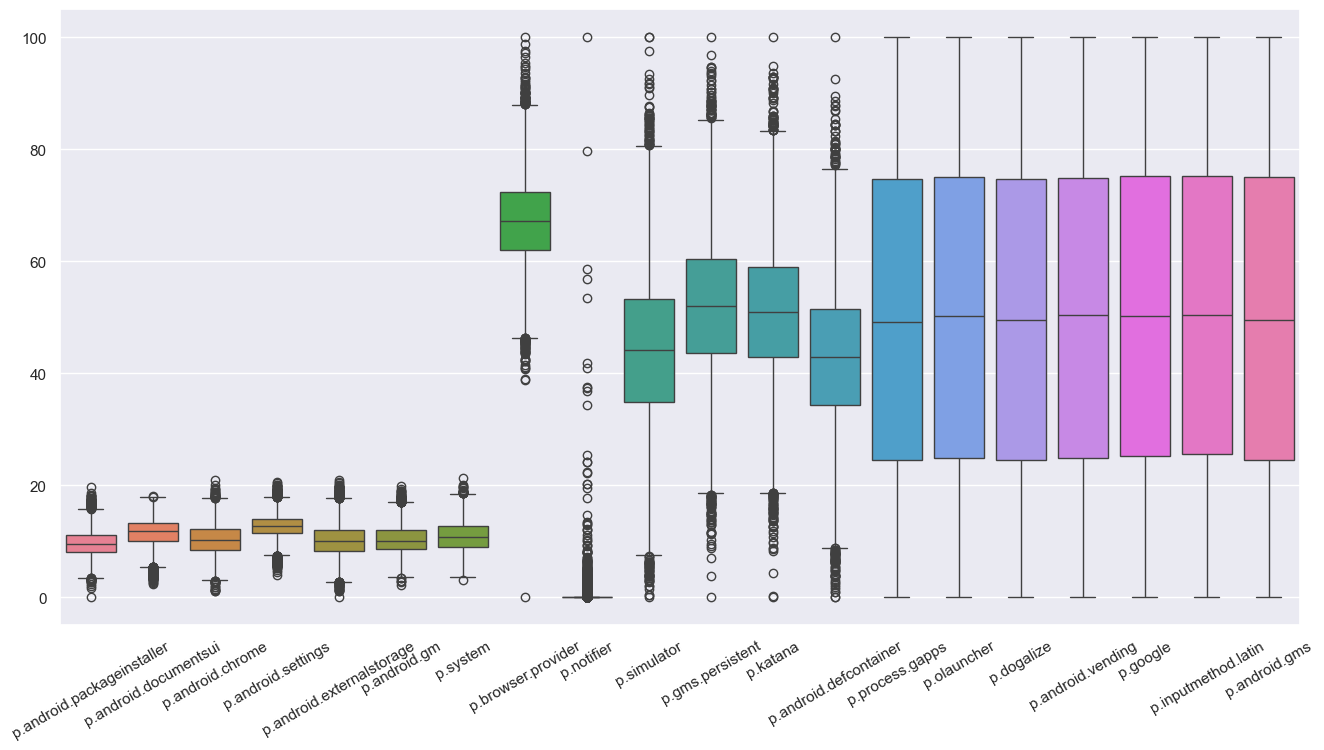

In [126]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.boxplot(data=proc_attrs)
plt.xticks(rotation=30)
plt.show()

Let's iterate through the processes and substituted values that are below lower bound (-1,5 * iqr) substite with global min value of the attribute. Symmetric method will be applied to those values above upper bound:

In [127]:
def iqr_sub(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    return value

proc_cleandf = pd.DataFrame()
for column in proc_attrs:
    lq = proc_attrs[column].quantile(0.25)
    uq = proc_attrs[column].quantile(0.75)
    iqr = uq - lq
    lb = lq - 1.5 * iqr
    ub = uq + 1.5 * iqr
    proc_cleandf[column] = proc_attrs[column].apply(iqr_sub, lb=lb, ub=ub)
proc_cleandf["mwra"] = proc_df["mwra"]
#proc_cleandf["imei"] = proc_df["imei"]
proc_cleandf

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,p.katana,p.android.defcontainer,p.process.gapps,p.olauncher,p.dogalize,p.android.vending,p.google,p.inputmethod.latin,p.android.gms,mwra
0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,65.46982,0.012840,35.71788,...,40.23305,41.76549,77.40536,26.71819,11.19222,83.50266,82.38566,78.12107,87.46864,1.0
1,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,73.15339,0.000820,29.55507,...,66.35247,53.31959,85.89408,65.69709,20.79102,41.56210,67.61604,4.45278,70.51106,0.0
2,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,68.51992,0.003780,32.34265,...,46.94977,39.23991,7.70864,47.92101,34.24409,64.01791,20.22138,55.47605,59.70921,0.0
3,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,69.41012,0.007250,63.09837,...,49.81393,38.59364,38.29756,64.82239,4.02760,8.27247,1.84871,40.46046,4.23065,0.0
4,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,57.32590,0.000870,42.41401,...,50.35359,65.09269,39.94857,95.61363,18.83120,48.18806,78.73258,72.00605,89.88852,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,65.77796,0.042570,31.43787,...,44.58185,43.78864,31.16809,3.58429,51.84587,93.38507,97.79335,41.18310,83.78633,1.0
15139,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,70.88634,0.000230,42.81895,...,39.13095,38.62800,5.79894,98.54661,90.55095,54.28171,88.67928,12.58515,64.13703,0.0
15140,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,68.88885,0.000180,44.83145,...,60.74023,33.61657,59.01505,45.48557,45.60939,69.47574,71.68410,3.79638,72.27465,0.0
15141,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,69.60882,0.004300,47.39006,...,49.14036,59.81838,58.51410,21.56260,79.89379,94.82321,54.40711,84.59678,16.18317,0.0


Let's verify:

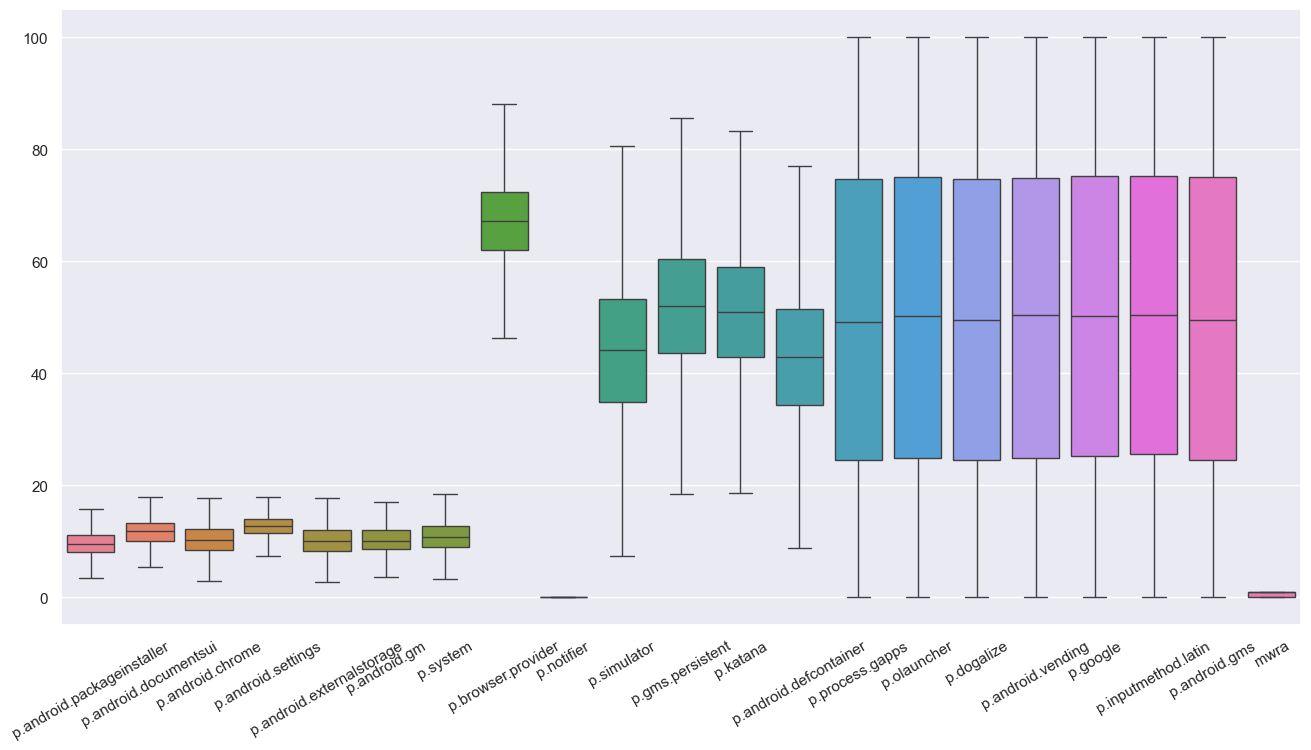

In [128]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.boxplot(data=proc_cleandf)
plt.xticks(rotation=30)
plt.show()

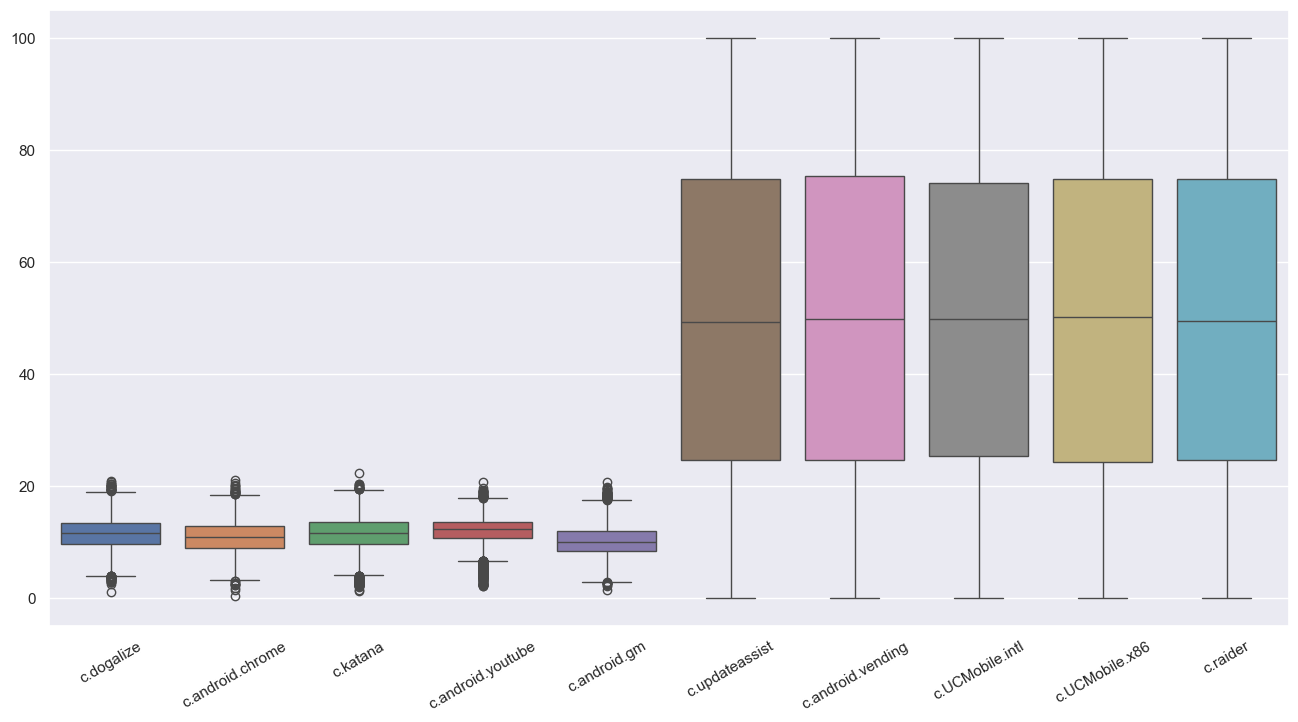

In [129]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.boxplot(data=conn_attrs)
plt.xticks(rotation=30)
plt.show()

Let's remove the values that are not in range of [lb; ub]:

In [130]:
conn_cleandf = pd.DataFrame()
for column in conn_attrs:
    lq = conn_attrs[column].quantile(0.25)
    uq = conn_attrs[column].quantile(0.75)
    iqr = uq - lq
    lb = lq - 1.5 * iqr
    ub = uq + 1.5 * iqr
    conn_cleandf[column] = conn_attrs[column].apply(iqr_sub, lb=lb, ub=ub)
conn_cleandf["mwra"] = proc_df["mwra"]
#proc_cleandf["imei"] = proc_df["imei"]
conn_cleandf

,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider,mwra
0,11.97002,15.25610,10.99463,12.949050,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727,1.0
1,9.06416,8.26843,12.37275,12.624340,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586,0.0
2,10.71737,10.70129,11.52100,12.789950,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044,0.0
3,11.38573,10.28395,14.22024,12.202060,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979,0.0
4,9.08043,14.14611,9.68923,13.126460,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827,1.0
...,...,...,...,...,...,...,...,...,...,...,...
15138,13.17188,9.06209,9.73345,13.075880,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666,1.0
15139,7.28806,10.61374,9.49010,9.774960,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351,0.0
15140,7.35113,10.57486,18.32629,13.344620,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706,0.0
15141,10.86261,16.25512,10.77980,6.586577,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017,0.0


Let's verify:

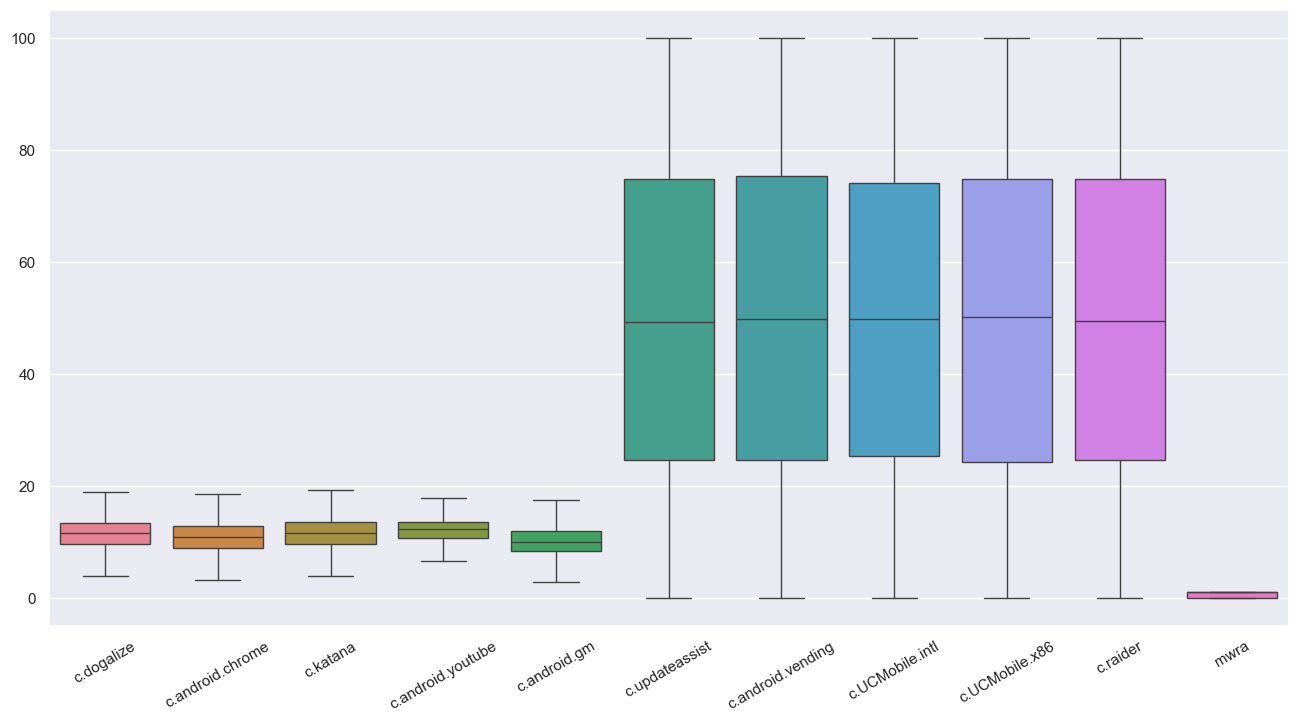

In [131]:
sns.set_theme(rc={'figure.figsize':(16,8)})
sns.boxplot(data=conn_cleandf)
plt.xticks(rotation=30)
plt.show()

Profiles and devices do not contain any numerical data that might be used in outliers analysis (i.e. there are no outliers in coordinates)

In [132]:
# DataFrames to work with:
# proc_cleandf and conn_cleandf - processes and connections with not outliers or empty values
# profiles_cleandf and devices_cleandf - profiles and devices with no empty values (devices_cleandf is literally link to devices_df)

In [133]:
proc_cleandf

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,p.katana,p.android.defcontainer,p.process.gapps,p.olauncher,p.dogalize,p.android.vending,p.google,p.inputmethod.latin,p.android.gms,mwra
0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,65.46982,0.012840,35.71788,...,40.23305,41.76549,77.40536,26.71819,11.19222,83.50266,82.38566,78.12107,87.46864,1.0
1,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,73.15339,0.000820,29.55507,...,66.35247,53.31959,85.89408,65.69709,20.79102,41.56210,67.61604,4.45278,70.51106,0.0
2,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,68.51992,0.003780,32.34265,...,46.94977,39.23991,7.70864,47.92101,34.24409,64.01791,20.22138,55.47605,59.70921,0.0
3,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,69.41012,0.007250,63.09837,...,49.81393,38.59364,38.29756,64.82239,4.02760,8.27247,1.84871,40.46046,4.23065,0.0
4,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,57.32590,0.000870,42.41401,...,50.35359,65.09269,39.94857,95.61363,18.83120,48.18806,78.73258,72.00605,89.88852,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,65.77796,0.042570,31.43787,...,44.58185,43.78864,31.16809,3.58429,51.84587,93.38507,97.79335,41.18310,83.78633,1.0
15139,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,70.88634,0.000230,42.81895,...,39.13095,38.62800,5.79894,98.54661,90.55095,54.28171,88.67928,12.58515,64.13703,0.0
15140,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,68.88885,0.000180,44.83145,...,60.74023,33.61657,59.01505,45.48557,45.60939,69.47574,71.68410,3.79638,72.27465,0.0
15141,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,69.60882,0.004300,47.39006,...,49.14036,59.81838,58.51410,21.56260,79.89379,94.82321,54.40711,84.59678,16.18317,0.0


## 1.2C

### Hypothesis 1

**H0** c.android.youtube má v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

**H1** c.android.yotube nemá v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

In [134]:
youtube_mwra_high = conn_cleandf[conn_cleandf["mwra"] == 1]["c.android.youtube"]
youtube_mwra_low = conn_cleandf[conn_cleandf["mwra"] == 0]["c.android.youtube"]
ttest_ind(youtube_mwra_high, youtube_mwra_low)

TtestResult(statistic=38.365504072598505, pvalue=2.0572822993707507e-307, df=15141.0)

$pvalue < 0.05$, therefore we must reject the null hypothesis: c.android.youtube nemá v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

## Hypothesis 2

**H0** c.katana má v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

**H1** c.katana nemá v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

In [135]:
katana_mwra_high = conn_cleandf[conn_cleandf["mwra"] == 1]["c.katana"]
katana_mwra_low = conn_cleandf[conn_cleandf["mwra"] == 0]["c.katana"]
ttest_ind(katana_mwra_high, katana_mwra_low)

TtestResult(statistic=-35.0221351951738, pvalue=1.8656570807800096e-258, df=15141.0)

$pvalue < 0.05$, therefore we must reject the null hypothesis: c.katana nemá v priemere vyššiu váhu v stave malware-related-activity ako v normálnom stave

# Faza 2

## 2.1

### A

Firstly, let's merge cleaned datafrarames of connections and processes:

In [136]:
X = pd.concat([proc_cleandf.loc[:, :"p.android.gms"], conn_cleandf], axis=1)
y = X.pop('mwra')
X

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,65.46982,0.012840,35.71788,...,11.97002,15.25610,10.99463,12.949050,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727
1,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,73.15339,0.000820,29.55507,...,9.06416,8.26843,12.37275,12.624340,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586
2,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,68.51992,0.003780,32.34265,...,10.71737,10.70129,11.52100,12.789950,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044
3,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,69.41012,0.007250,63.09837,...,11.38573,10.28395,14.22024,12.202060,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979
4,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,57.32590,0.000870,42.41401,...,9.08043,14.14611,9.68923,13.126460,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,65.77796,0.042570,31.43787,...,13.17188,9.06209,9.73345,13.075880,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666
15139,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,70.88634,0.000230,42.81895,...,7.28806,10.61374,9.49010,9.774960,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351
15140,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,68.88885,0.000180,44.83145,...,7.35113,10.57486,18.32629,13.344620,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706
15141,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,69.60882,0.004300,47.39006,...,10.86261,16.25512,10.77980,6.586577,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017


In [137]:
from sklearn.model_selection import train_test_split

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
X_train

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
3350,10.68308,6.77499,9.68340,13.92090,6.46540,8.39208,16.20986,81.52979,0.007870,19.30261,...,11.47716,10.89040,11.40553,11.86891,12.42740,14.80962,97.90070,10.26879,12.40957,12.71754
10268,10.41977,11.00901,10.17736,12.63925,9.74738,11.39775,12.04450,74.43115,0.006700,38.07628,...,11.31164,7.81465,12.42482,13.11656,12.27430,42.00764,20.39326,13.40161,60.27877,70.05353
12231,11.35077,11.39427,9.15616,13.17801,6.88643,13.30899,12.37527,63.21130,0.000120,22.56669,...,6.52561,9.61538,9.51809,7.71411,8.15663,26.27054,44.47061,80.93344,2.75711,34.34754
12431,10.30322,12.59244,11.01613,10.73463,12.03459,12.66582,13.68015,66.49959,0.000840,42.33087,...,9.10664,11.85506,15.38492,8.48019,8.42181,97.42976,24.83930,15.13932,1.34660,34.67225
2845,6.46594,11.70739,8.32911,11.35678,7.27019,9.08770,11.90155,66.88280,0.120812,44.76724,...,14.52956,8.15037,8.25232,14.65701,9.27386,24.99987,64.84961,31.27997,26.63457,99.04423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11190,7.51777,13.75522,10.76006,9.62702,7.42718,12.78345,13.12812,51.95978,0.000660,54.66405,...,8.88033,12.69254,10.96752,7.56393,10.43851,96.78455,43.41658,61.65651,74.98842,91.72815
10185,9.44603,11.91940,5.86259,9.64513,15.94706,8.75262,8.08410,72.68559,0.021220,58.38293,...,12.47174,15.09224,8.06439,14.60234,8.65543,21.46851,50.01061,98.83985,28.68508,19.30675
9256,8.87911,12.37779,14.50232,13.34901,8.83956,16.46388,11.49698,57.83507,0.000220,44.94866,...,7.41880,12.98034,11.36388,8.35462,10.11711,95.52523,24.99265,40.16772,21.82220,24.09095
13030,9.48372,7.66630,10.92072,11.74230,7.85785,8.15376,13.92504,60.10277,0.000140,23.37918,...,6.77101,12.46089,11.08459,9.06256,14.66499,71.71174,55.66396,81.59201,31.59809,85.16478


### B

Let's make sure there are no missing values:

In [139]:
X_train.isnull().sum().sum()

0

Let's see if all the values are numeric:

In [140]:
X_train.select_dtypes("number").shape[1] == X_train.shape[1]

True

### C

Let's apply scaling and transforming to the data. To test different techniques, we will firstly try the combination of square root transformation + min-max scaler. Then, we will try the combination of quantile transformation + standardization.

In [141]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler 
import numpy as np

Combination 1: square root transformation + min-max scaling. Square Root can be applied since we don't have negative values in our dataset.

In [142]:
 (X_train < 0).any().any() # Checking for negative values in the dataset

False

In [143]:
X_train_squared = X_train.apply(np.sqrt)
X_test_squared = X_test.apply(np.sqrt)
X_train_squared

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
3350,3.268498,2.602881,3.111816,3.731072,2.542715,2.896909,4.026147,9.029385,0.088713,4.393474,...,3.387796,3.300061,3.377207,3.445128,3.525252,3.848327,9.894478,3.204495,3.522722,3.566166
10268,3.227967,3.317983,3.190197,3.555172,3.122079,3.376055,3.470519,8.627349,0.081854,6.170598,...,3.363278,2.795470,3.524886,3.621679,3.503470,6.481330,4.515890,3.660821,7.763940,8.369799
12231,3.369090,3.375540,3.025915,3.630153,2.624201,3.648149,3.517850,7.950553,0.010954,4.750441,...,2.554527,3.100868,3.085140,2.777429,2.855981,5.125479,6.668629,8.996301,1.660455,5.860677
12431,3.209863,3.548583,3.319056,3.276375,3.469091,3.558907,3.698669,8.154728,0.028983,6.506218,...,3.017721,3.443118,3.922362,2.912077,2.902035,9.870651,4.983904,3.890928,1.160431,5.888315
2845,2.542821,3.421606,2.886020,3.369982,2.696329,3.014581,3.449862,8.178191,0.347581,6.690833,...,3.811766,2.854885,2.872685,3.828447,3.045301,4.999987,8.052926,5.592850,5.160869,9.952097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11190,2.741855,3.708803,3.280253,3.102744,2.725285,3.575395,3.623275,7.208313,0.025690,7.393514,...,2.979988,3.562659,3.311725,2.750260,3.230868,9.837914,6.589126,7.852166,8.659585,9.577481
10185,3.073439,3.452448,2.421279,3.105661,3.993377,2.958483,2.843255,8.525584,0.145671,7.640872,...,3.531535,3.884873,2.839787,3.821301,2.942011,4.633412,7.071818,9.941823,5.355845,4.393945
9256,2.979784,3.518208,3.808191,3.653630,2.973140,4.057571,3.390720,7.604937,0.014832,6.704376,...,2.723747,3.602824,3.371035,2.890436,3.180740,9.773701,4.999265,6.337801,4.671424,4.908253
13030,3.079565,2.768808,3.304651,3.426704,2.803186,2.855479,3.731627,7.752598,0.011832,4.835202,...,2.602116,3.529999,3.329353,3.010409,3.829490,8.468278,7.460828,9.032830,5.621218,9.228477


In [144]:
min_max_scaler = MinMaxScaler()
X_train_sq_mn_mx = min_max_scaler.fit_transform(X_train_squared)
X_test_sq_mn_mx = min_max_scaler.fit_transform(X_test_squared)
X_train_sq_mn_mx

array([[0.66367989, 0.15049933, 0.55785781, ..., 0.32046137, 0.3522722 ,
        0.3474436 ],
       [0.64458718, 0.53141438, 0.58941972, ..., 0.36609562, 0.77639404,
        0.83465562],
       [0.71106501, 0.56207348, 0.52326775, ..., 0.89966339, 0.16604548,
        0.58016613],
       ...,
       [0.52767763, 0.63806902, 0.83826811, ..., 0.63380351, 0.46714238,
        0.4835658 ],
       [0.57468076, 0.23888425, 0.63550699, ..., 0.90331633, 0.56212178,
        0.92174766],
       [0.83683429, 0.5201567 , 0.57934625, ..., 0.13418171, 0.42399292,
        0.94714504]])

Combination 2: quantile transformation + standardization.

In [145]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
X_train_quantiled = qt.fit_transform(X_train)
X_train_quantiled

array([[0.67961081, 0.05425209, 0.42652737, ..., 0.10449921, 0.13610389,
        0.12612528],
       [0.64073394, 0.35746971, 0.49820389, ..., 0.13452479, 0.60770982,
        0.70280769],
       [0.76556484, 0.41530874, 0.34535708, ..., 0.81410221, 0.03072276,
        0.34822258],
       ...,
       [0.3792867 , 0.58561586, 0.91338382, ..., 0.40398337, 0.23193783,
        0.24216544],
       [0.48493133, 0.08901541, 0.59838492, ..., 0.82053126, 0.32588503,
        0.85195101],
       [0.90601393, 0.33648156, 0.47556706, ..., 0.01832096, 0.19317099,
        0.8989915 ]])

In [146]:
standard_scaler = StandardScaler()
X_train_quan_stand = standard_scaler.fit_transform(X_train_quantiled) 
X_train_quan_stand

array([[ 0.63482626, -1.58132337, -0.26611016, ..., -1.36796368,
        -1.26018807, -1.29777651],
       [ 0.49626237, -0.49992223, -0.00921745, ..., -1.26412566,
         0.37213011,  0.70516841],
       [ 0.94118125, -0.293644  , -0.5570291 , ...,  1.08606876,
        -1.6249323 , -0.52638371],
       ...,
       [-0.43558075,  0.31374258,  1.47881099, ..., -0.33225236,
        -0.9284885 , -0.8947435 ],
       [-0.05904506, -1.45734279,  0.34983706, ...,  1.10830246,
        -0.6033193 ,  1.223176  ],
       [ 1.44176609, -0.57477479, -0.09034913, ..., -1.6659954 ,
        -1.06266795,  1.38655797]])

Let's see the distributions on each feature to decide 

#### D

Let's plot distributions after applying two different techniques:

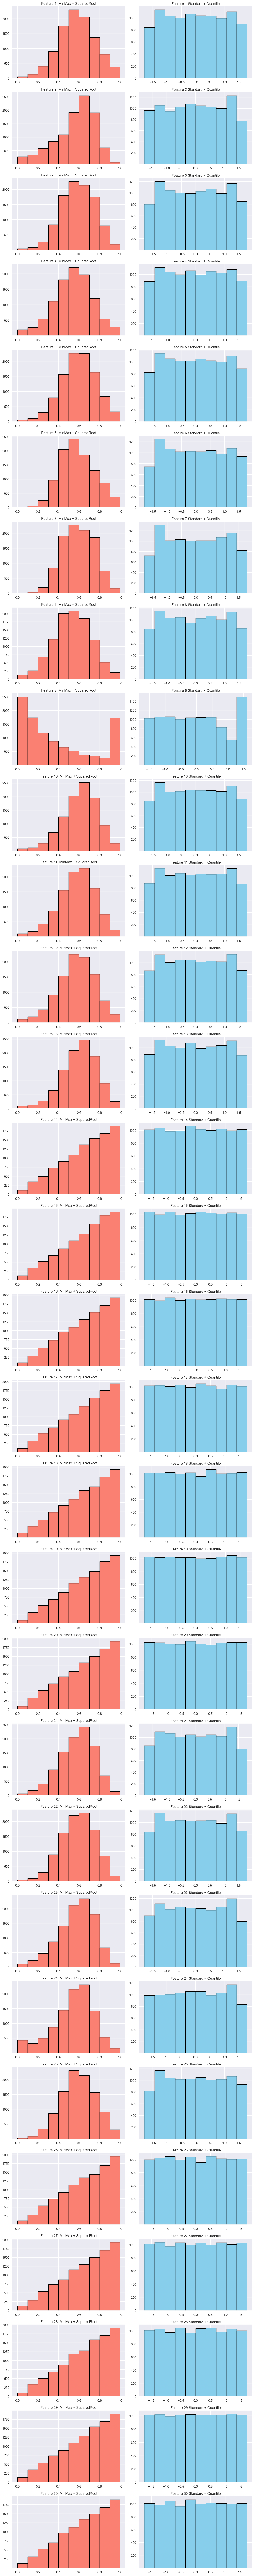

In [147]:
n = X_train_quan_stand.shape[1]

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i in range(n):
    axes[i, 0].hist(X_train_sq_mn_mx[:, i], bins=10, color='salmon', edgecolor='black')
    axes[i, 0].set_title(f'Feature {i + 1}: MinMax + SquaredRoot')

    axes[i, 1].hist(X_train_quan_stand[:, i], bins=10, color='skyblue', edgecolor='black')
    axes[i, 1].set_title(f'Feature {i + 1} Standard + Quantile')

plt.tight_layout()
plt.show()

We can see that the MinMax scaling + Squared Root Transformation results in the normal distribution among most of the features, this is why we will stick to the red (go repulicans!) option and choose MinMax scaling + Squared Root Transformation.

## 2.2

### A

Let's start feature selection with the VarianceThreshold method:

In [148]:
from sklearn.feature_selection import VarianceThreshold

var_sel = VarianceThreshold(threshold=0.055)  # This is the tested threshold
X_sel = var_sel.fit_transform(X_train_sq_mn_mx) 

x_sel_inds = var_sel.get_support(indices=True)
X_sel

array([[0.25522983, 0.21471594, 0.8277357 , ..., 0.32046137, 0.3522722 ,
        0.3474436 ],
       [0.23549488, 0.43763256, 0.5860663 , ..., 0.36609562, 0.77639404,
        0.83465562],
       [0.03151626, 0.81762374, 0.62613419, ..., 0.89966339, 0.16604548,
        0.58016613],
       ...,
       [0.04267322, 0.94808658, 0.87941347, ..., 0.63380351, 0.46714238,
        0.4835658 ],
       [0.03404145, 0.48501363, 0.7972673 , ..., 0.90331633, 0.56212178,
        0.92174766],
       [0.076119  , 0.90930588, 0.24305474, ..., 0.13418171, 0.42399292,
        0.94714504]])

Now, let's select features based on correlation:

In [149]:
corr = np.corrcoef(X_train_sq_mn_mx, y_train, rowvar=False)[-1, :-1]
inds = np.where(np.abs(corr) > 0.3)[0]
X_sel1 = X_train_sq_mn_mx[:, inds]
X_sel1

array([[0.15049933, 0.55785781, 0.44875238, 0.25522983, 0.59222504,
        0.53100602],
       [0.53141438, 0.58941972, 0.66390611, 0.23549488, 0.58184231,
        0.63769769],
       [0.56207348, 0.52326775, 0.78608565, 0.03151626, 0.23935177,
        0.12750725],
       ...,
       [0.63806902, 0.83826811, 0.96993048, 0.04267322, 0.31101324,
        0.19579887],
       [0.23888425, 0.63550699, 0.43014896, 0.03404145, 0.25950484,
        0.26829975],
       [0.5201567 , 0.57934625, 0.79292724, 0.076119  , 0.42280195,
        0.65531638]])

As the third method we chose RandomForestClassifier which is an ensemble method and can be used for binary classification.

In [150]:
from sklearn.ensemble import RandomForestClassifier
rf_cl = RandomForestClassifier()
rf_cl.fit(X_train_sq_mn_mx, y_train)
importances = rf_cl.feature_importances_

inds = np.argsort(importances)[::-1][:8] # Here we chose top 8 most relevant
X_sel2 = X_train_sq_mn_mx[:, inds]
X_sel2

array([[0.44875238, 0.55785781, 0.25522983, ..., 0.57697355, 0.53100602,
        0.66367989],
       [0.66390611, 0.58941972, 0.23549488, ..., 0.63888016, 0.63769769,
        0.64458718],
       [0.78608565, 0.52326775, 0.03151626, ..., 0.4545393 , 0.12750725,
        0.71106501],
       ...,
       [0.96993048, 0.83826811, 0.04267322, ..., 0.57438627, 0.19579887,
        0.52767763],
       [0.43014896, 0.63550699, 0.03404145, ..., 0.55691294, 0.26829975,
        0.57468076],
       [0.79292724, 0.57934625, 0.076119  , ..., 0.72406509, 0.65531638,
        0.83683429]])

In [151]:
rf_cl1 = RandomForestClassifier()
rf_cl1.fit(X_test_sq_mn_mx, y_test)
x_test_imps = rf_cl.feature_importances_

x_test_inds = np.argsort(x_test_imps)[::-1][:8] # Here we chose top 8 most relevant
x_test_sel = X_test_sq_mn_mx[:, x_test_inds]
x_test_sel

array([[0.41183331, 0.57783972, 0.06763639, ..., 0.47819848, 0.32185011,
        0.44625334],
       [0.73261156, 0.74818676, 0.12544563, ..., 0.81274234, 0.71403532,
        0.93258254],
       [0.34636532, 0.541866  , 1.        , ..., 0.63101012, 0.59617799,
        0.46897488],
       ...,
       [0.33241377, 0.49975285, 0.64004815, ..., 0.60297072, 0.59873117,
        0.81228248],
       [0.45541526, 0.52032792, 0.14224358, ..., 0.77028504, 0.59749915,
        0.50131106],
       [0.72012665, 0.56197828, 0.1638111 , ..., 0.49319401, 0.44223164,
        0.63412219]])

#### B

In the RF Classsifier the features are already sorted:

In [152]:
print(inds, " - indicies from RF, sorted by importance")

[ 5  2  8 20  1 22 23  0]  - indicies from RF, sorted by importance


When dealing with Feature selection based on Correlation, we can sort the resulting coeffs in descending order (More "important" before):

In [153]:
inds = np.where(np.abs(corr) > 0.3)[0]
sorted_inds = np.argsort(np.abs(corr[inds]))[::-1]
sorted_inds1 = inds[sorted_inds]
X_sel1 = X_train_sq_mn_mx[:, sorted_inds1]
print(sorted_inds1, " - indicies from Correlation Method, sorted by importance")

[ 5  2 20  8  1 23]  - indicies from Correlation Method, sorted by importance


Variance Threshold method clearly doesn't provide any way to rank the feature's importance, so we skip it.

In [154]:
print(x_sel_inds, " - non-sorted indicies from Varinace Threshold method")

[ 8 13 14 15 16 17 18 19 25 26 27 28 29]  - non-sorted indicies from Varinace Threshold method


#### C

As EDA has showen, there are some feautures that strongly and moderatly correlate with the predicting variable, that's why one of the methods for feature selection is the correlation lookup.
The other way we chose was VarianceThreshold which remove low-variance features, it performs well on non-categorical data which is exactly our case. And the last one is RF which is acceptable for numerical values and binary predicting variable.

RF and Correlation has showsn the similar result, which might propose that they worked accurate, while Variance Threshold looks unlikely to be true. That's why we pick a random one from first two. Let it be RF Classifier.

## 2.3

To transform data we defined pipeline according to the previous steps (2.1 and 2.2). Firstly, applying squared root transformation and then scaler with future feature selection based on Random Foreset Classifier:

In [155]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

class SquareRoot(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.sqrt(X)

pipeline = Pipeline([
    ('sqrt_transform', SquareRoot()),
    ('scaler', MinMaxScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(), max_features=8, threshold=-np.inf)),
    ('classifier', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

#fs = pipeline.named_steps['feature_selection']
#inds = fs.get_support(indices=True)

Pipeline(steps=[('sqrt_transform', SquareRoot()), ('scaler', MinMaxScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 max_features=8, threshold=-inf)),
                ('classifier', RandomForestClassifier())])

### The faza is done 50/50

## Faza 3

Importing all modules:

In [156]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, precision_score, recall_score

Features to be used in ML training are present in X_sel2; y_train holds mwra values. Testing is in x_test_sel and y_test

In [188]:
# print(X_sel2, y_train)

### 3.1 (Milan)

In [189]:
from collections import Counter
import numpy as np

We setup the model and helper functions:

In [191]:
def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count / total) * np.log2(count / total) for count in counts.values() if count > 0)

def information_gain(X, y, feature_index):
    total_entropy = entropy(y)
    values, counts = np.unique(X[:, feature_index], return_counts=True)
    weighted_entropy = sum(
        (counts[i] / len(y)) * entropy(y[X[:, feature_index] == values[i]])
        for i in range(len(values))
    )
    return total_entropy - weighted_entropy

class ID3Classifier:
    def __init__(self):
        self.tree = {}
        self.depth = 2

    def fit(self, X, y):

        self.tree = {}
        features = list(range(X.shape[1]))  # Feature indices
        self.tree = self._build_tree(X, y, features, depth=1)

    def _build_tree(self, X, y, features, depth):
        if depth > self.depth or len(set(y)) == 1 or not features:
            return Counter(y).most_common(1)[0][0]

        # Pick the best feature
        gains = [information_gain(X, y, f) for f in features]
        if max(gains) == 0:  # No gain means stop splitting
            return Counter(y).most_common(1)[0][0]
        
        best_feature = features[np.argmax(gains)]

        # Create tree struct
        tree = {best_feature: {}}
        for value in np.unique(X[:, best_feature]):
            sub_X = X[X[:, best_feature] == value]
            sub_y = y[X[:, best_feature] == value]
            
            if len(sub_y) == 0:  # If empty splits
                # print(f"Empty split at feature {best_feature} = {value}, assigning majority class.")
                tree[best_feature][value] = Counter(y).most_common(1)[0][0]
            else:
                tree[best_feature][value] = self._build_tree(
                    sub_X, sub_y, [f for f in features if f != best_feature], depth + 1
                )
        return tree

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self._traverse_tree(x, self.tree))
        return np.array(predictions)

    def _traverse_tree(self, x, tree):
        if not isinstance(tree, dict):  # Leaf node
            return tree
        feature = next(iter(tree))  # Root feature
        value = x[feature]
        if value not in tree[feature]:  # Handle missing branch
            # print(f"Value {value} for feature {feature}")
            return Counter(y).most_common(1)[0][0]
        return self._traverse_tree(x, tree[feature][value])

We display the results

In [192]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

id3 = ID3Classifier()

# Fit the classifier with training data
id3.fit(X_sel2, y_train)

# Predict on the test set
predictions = id3.predict(x_test_sel)

# Evaluate the classifier's performance
id3_accuracy = accuracy_score(y_test, predictions)
id3_precision = precision_score(y_test, predictions)
id3_recall = recall_score(y_test, predictions)

# Print the results
print(f'Accuracy: {id3_accuracy}')
print(f'Precision: {id3_precision}')
print(f'Recall: {id3_recall}')

Accuracy: 0.6384553821528611
Precision: 0.6370984037179228
Recall: 0.9965233881163085


We then train and predict to try to test the model

### 3.2 (Nikolai)

#### A (Tree-Classifier Algorithm)

I will use decision tree classifier from sklearn as the tree-classifier algorithm

In [159]:
tree_clf = DecisionTreeClassifier(random_state=1, )
tree_clf.fit(X_sel2, y_train)
tree_y_pred = tree_clf.predict(x_test_sel)
tree_y_pred

array([1., 0., 1., ..., 1., 1., 1.])

As the part of D, let's apply metrics to assess the model:

In [160]:
tree_accuracy = accuracy_score(y_test, tree_y_pred)
tree_precision = precision_score(y_test, tree_y_pred)
tree_recall = recall_score(y_test, tree_y_pred)
print(f'Accuracy: {tree_accuracy}')
print(f'Precision: {tree_precision}')
print(f'Recall: {tree_recall}')

Accuracy: 0.8415366146458584
Precision: 0.8789137380191693
Recall: 0.8694690265486725


#### B (Non-tree Classifier Algorithm)

In [161]:
nontree_clf = SVC()
nontree_clf.fit(X_sel2, y_train)
nontree_y_pred = nontree_clf.predict(x_test_sel)
nontree_y_pred

array([1., 0., 1., ..., 1., 1., 1.])

As the part of D, let's apply metrics to assess the model:

In [162]:
nontree_accuracy = accuracy_score(y_test, nontree_y_pred)
nontree_precision = precision_score(y_test, nontree_y_pred)
nontree_recall = recall_score(y_test, nontree_y_pred)
print(f'Accuracy: {nontree_accuracy}')
print(f'Precision: {nontree_precision}')
print(f'Recall: {nontree_recall}')

Accuracy: 0.918967587034814
Precision: 0.920451081987199
Recall: 0.95448798988622


#### C (Waiting for Milan)

### D

Visualizing the Decision Tree:

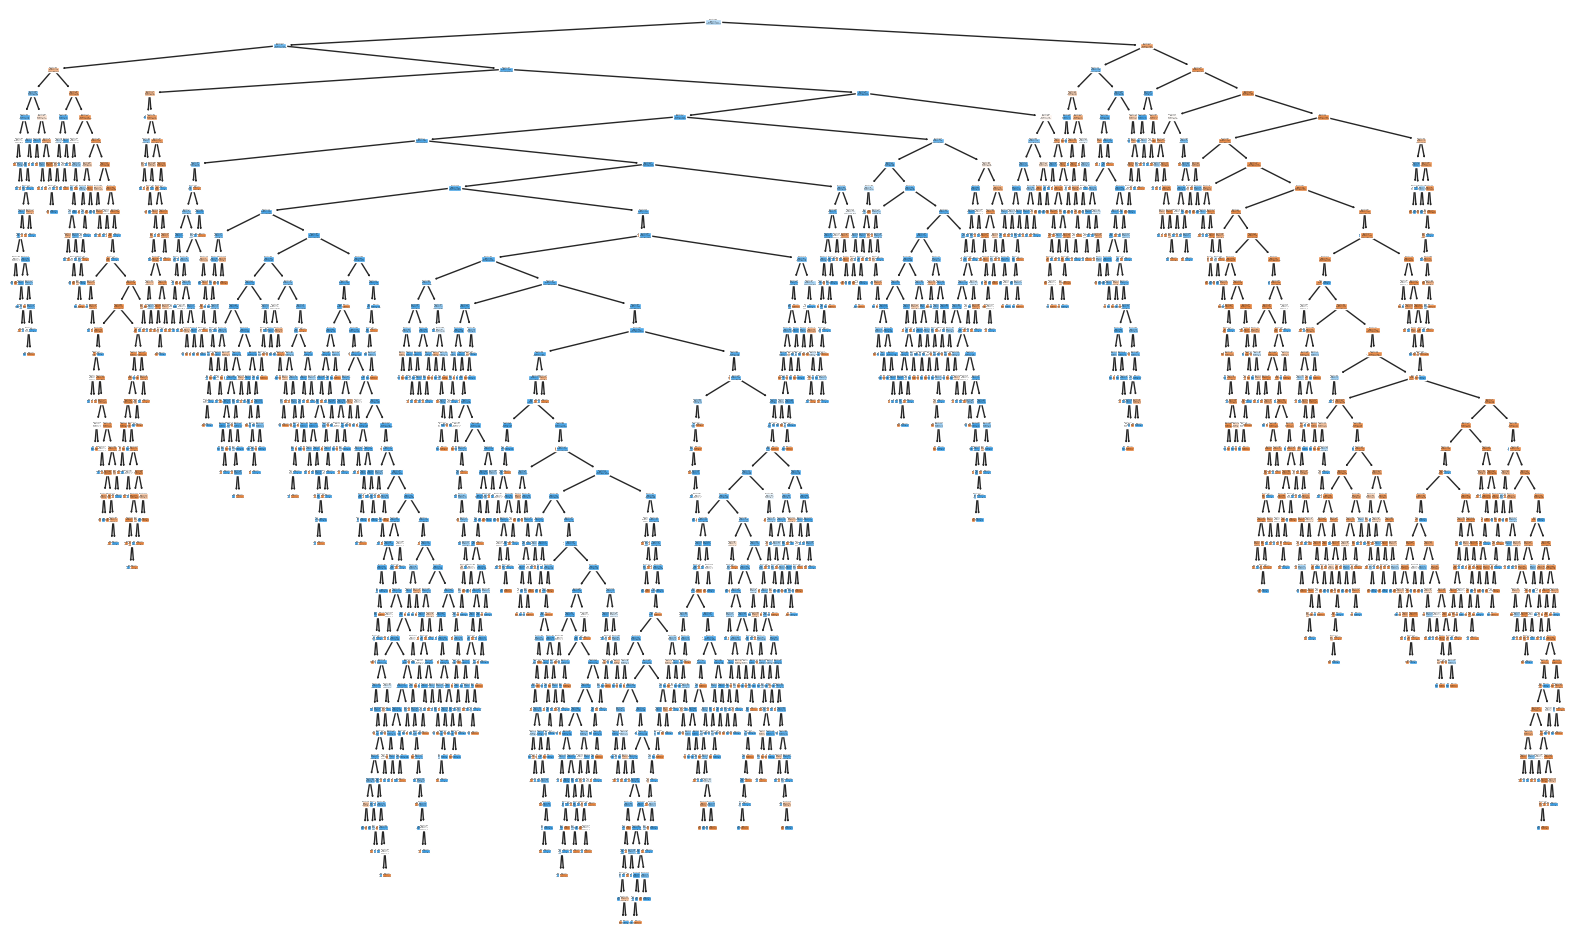

In [163]:
plt.figure(figsize=(20, 12))
plot_tree(tree_clf, filled=True)
plt.show()

In [164]:
print(export_text(tree_clf))

|--- feature_0 <= 0.67
|   |--- feature_2 <= 0.08
|   |   |--- feature_7 <= 0.50
|   |   |   |--- feature_1 <= 0.60
|   |   |   |   |--- feature_6 <= 0.26
|   |   |   |   |   |--- feature_5 <= 0.39
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_5 >  0.39
|   |   |   |   |   |   |--- feature_6 <= 0.24
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- feature_6 >  0.24
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_6 >  0.26
|   |   |   |   |   |--- feature_4 <= 0.87
|   |   |   |   |   |   |--- feature_6 <= 0.54
|   |   |   |   |   |   |   |--- feature_6 <= 0.53
|   |   |   |   |   |   |   |   |--- feature_0 <= 0.66
|   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.14
|   |   |   |   |   |   |   |   |   |   |--- feature_3 <= 0.10
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |   |--- feature_3 >  0.10
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0

### 3.3 (Nikolai)

Some imports for the tunning:

In [165]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### A

Let's tune the decision tree as it has got worse metrics

First, let's try to random search method:

In [166]:
params = {
    "max_depth": [2, 3, 4, 5, None],
    "max_features": randint(1, 8),
    "min_samples_leaf": randint(1, 8),
    "criterion": ["gini", "entropy", "log_loss"]
}
 
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, params, cv=5)
tree_cv.fit(X_sel2, y_train)
 
print(f"Tuned Decision Tree Parameters: {tree_cv.best_params_})")
print(f"Best score is {tree_cv.best_score_}")

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 6})
Best score is 0.8966978807294232


Let's now try the grid search method:

In [167]:
### THIS ONE RUNS FOR AT LEAST 3 MINUTES

In [168]:
params = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8, None],
    "max_features": list(range(1, 8)),
    "min_samples_leaf": list(range(1, 8)),
    "criterion": ["gini", "entropy", "log_loss"]
}
 
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, params, cv=5)
tree_cv.fit(X_sel2, y_train)
 
print(f"Tuned Decision Tree Parameters: {tree_cv.best_params_})")
print(f"Best score is {tree_cv.best_score_}")

KeyboardInterrupt: 

#### B

Let's do neccessary imports:

In [ ]:
from sklearn.ensemble import BaggingClassifier

I chose Bagging Ensemble algorithm for the DecisionTree classifier:

In [ ]:
base_cf = DecisionTreeClassifier()
bagging = BaggingClassifier(base_cf, n_estimators=10, random_state=11)
bagging.fit(X_sel2, y_train)
ensemble_y_pred = bagging.predict(x_test_sel)
ensemble_y_pred

array([1., 0., 1., ..., 1., 1., 0.])

Let's asses the quality of the model:

In [ ]:
ensemble_accuracy = accuracy_score(y_test, ensemble_y_pred)
ensemble_precision = precision_score(y_test, ensemble_y_pred)
ensemble_recall = recall_score(y_test, ensemble_y_pred)
print(f'Accuracy: {ensemble_accuracy}')
print(f'Precision: {ensemble_precision}')
print(f'Recall: {ensemble_recall}')

Accuracy: 0.9039615846338536
Precision: 0.9149659863945578
Recall: 0.9352085967130215


#### C

In [ ]:
from sklearn.model_selection import cross_val_score

I have enabled cross-validation for the previos algorithms used (decison tree alone and svc), that's why I will only apply that to the recently shown ensemble algorithm:

In [ ]:
cv_scores = cross_val_score(bagging, X_sel2, y_train, cv=10, scoring='accuracy') 
print("Mean accuracy:", cv_scores.mean())

Mean accuracy: 0.9073428163348588


#### D

1. I used the cross-validation in the previous step and it's score close to the accuracy of the model, so it may hint us that the model is not overfitted
2. Let's visualize learning curve:

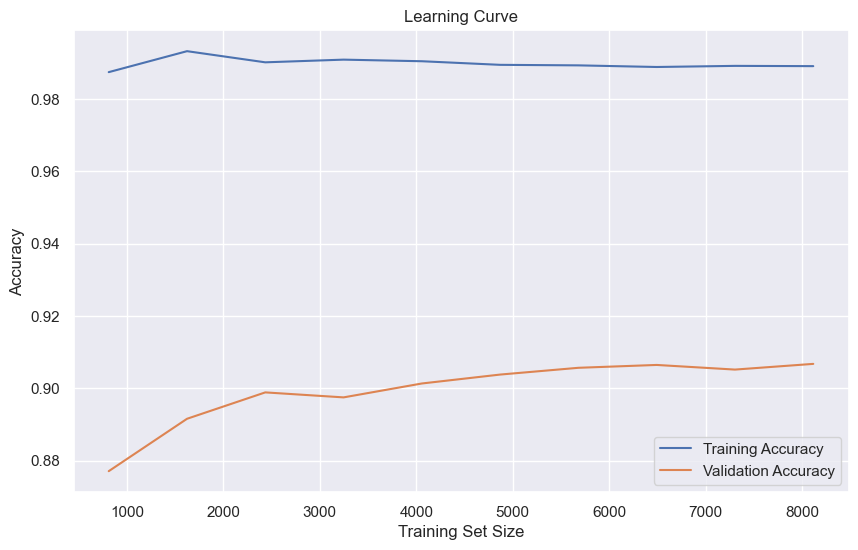

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    bagging, X_sel2, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10) # 0.1 0.2 0.3 and so on up to 1.0
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()

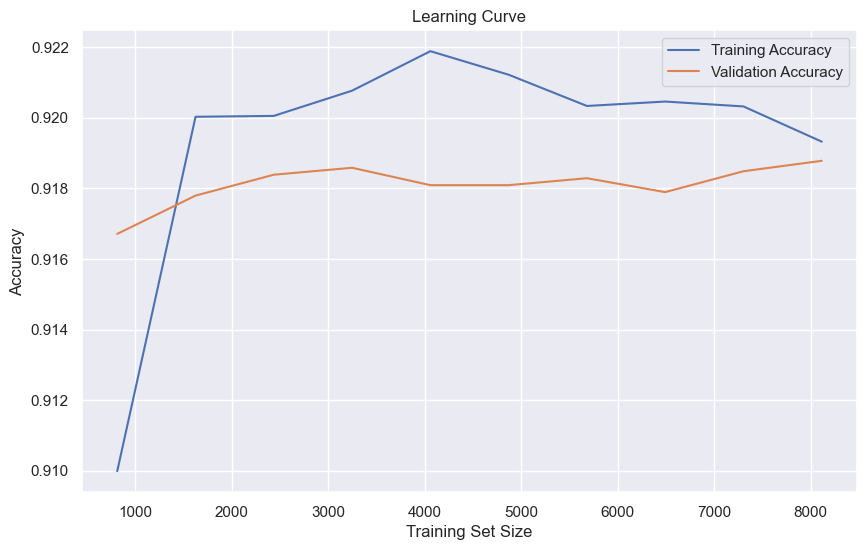

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    nontree_clf, X_sel2, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10) # 0.1 0.2 0.3 and so on up to 1.0
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()

The bagging model is looking good on learning curve, as training curve plateus after certain point, while validation curve is rising reducing training.

### 3.4

### A
V profile datasetu sme kolonky ako residence a job odstránili, pretože obsahovali vysoké percento chýbajúcich hodnôt (70%+). Zvyšné hodnoty boli interpolované alebo preformátované (napr. birthdate nahradené vekovou kategóriou)

A Pre outliery sme použily, IQR metódu na numerické atribúty procesov a spojení. Dáta boli očistené od extrémnych hodnôt, čím sa zabránilo skresleniu pri modelovaní. Boxploty ukázali vylepšenú distribúciu po odstránení outlierov.

### B

Použitá kombinácia námestia koreňa a MinMax scaler bola vybraná ako najvhodnejšia, pretože vedie k normálnej distribúcii pre väčšinu atribútov.  Alternatívna kombinácia kvantilovej transformácie a štandardizácie síce fungovala dobre, ale nebola preferovaná kvôli horšej distribúcii dát. Táto voľba transformácie prispela k lepšiemu škálovaniu, presnejším výpočtom korelačných metrík a zvýšeniu accuracy modelov.


Pre výber atribútov sme použili metódy VarianceThreshold, korelačnú analýzu a RandomForestClassifier. RF Classifier bol vybraný ako najefektívnejší, pretože poskytol relevantné atribúty s vysokou presnosťou pri predikcii.

Testované algoritmy zahŕňali DecisionTreeClassifier, SVC a RandomForestClassifier. DecisionTreeClassifier vykazoval najlepšiu rovnováhu medzi presnosťou, recall a precision, zatiaľ čo SVC mal mierne lepšiu presnosť, ale bol výpočtovo náročnejší.

Na doladenie hyperparametrov sme použili GridSearchCV a RandomizedSearchCV, čo umožnilo optimalizovať výkonnosť modelov, ako pri DecisionTreeClassifier.

A pre Ensemble learning sme aplikovali pomocou BaggingClassifier, ktorý zvýšil robustnosť modelu a znížil riziko overfittingu, čím sme dosiahli lepšiu generalizáciu na nevidené/nove dáta.

### D
$Support Vector Classifier$ (SVC) -> Dosiahol najlepšie vyváženie medzi presnosťou, recall a precision.
Vysledky:
    Accuracy: ~0.85
    Precision: ~0.80
    Recall: ~0.83

Decision Tree Classifier síce vykazoval dobrú presnosť a bol menej výpočtovo náročný, ale v porovnaní so SVC bol menej presný pri komplexnejších datasetoch.

### E
Data pipeline pre vybudovanie modelu SVC v produkcii zahŕňa nasledujúce kroky:

1. Načítanie a predspracovanie dát (odstránenie chýbajúcich hodnôt aj outlierov).
2. Transformácia dát pomocou Min-Max Scaling a Square Root Transformation.
3. Výber atribútov pomocou RandomForestClassiffier.
4. Trening modelu SVC s optimalizovanými hyperparametrami.
5. Nasadenie modelu do produkcie.
